In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tqdm import tqdm

def load_and_preprocess_data(sar_dir, label_dir):
    """
    Load and preprocess SAR and label images based on the reference implementation
    """
    # Get list of files
    sar_files = sorted([f for f in os.listdir(sar_dir) if f.endswith(('.tif', '.png', '.jpg'))])
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith(('.tif', '.png', '.jpg'))])
    
    image_dataset = []
    mask_dataset = []
    
    print("Loading and preprocessing images...")
    for sar_file, label_file in tqdm(zip(sar_files, label_files)):
        # Load SAR image
        sar_path = os.path.join(sar_dir, sar_file)
        image = cv2.imread(sar_path, -1)  # -1 for unchanged mode
        
        # Load label image
        label_path = os.path.join(label_dir, label_file)
        mask = cv2.imread(label_path, -1)
        
        # Verify images were loaded successfully and have correct size
        if image is None or mask is None:
            print(f"Warning: Could not load {sar_file} or {label_file}")
            continue
            
        if image.shape[:2] != (128, 128) or mask.shape[:2] != (128, 128):
            print(f"Warning: Unexpected image size in {sar_file} or {label_file}")
            continue
        
        # Ensure SAR image is single channel
        if len(image.shape) > 2:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Add to datasets
        image_dataset.append(image)
        mask_dataset.append(mask)
    
    # Convert to numpy arrays
    image_dataset = np.array(image_dataset)
    mask_dataset = np.array(mask_dataset)
    
    
    print(f"\nLoaded {len(image_dataset)} image pairs successfully")
    print(f"SAR array shape: {image_dataset.shape}")
    print(f"Label array shape: {mask_dataset.shape}")

    
    return image_dataset, mask_dataset

# Usage example:
image_dataset, mask_dataset = load_and_preprocess_data(
     sar_dir='/kaggle/input/sample-data-openearthmap/sar_sample (1)',
     label_dir='/kaggle/input/sample-data-openearthmap/label_sample (1)'
 )

Loading and preprocessing images...


5000it [01:09, 71.74it/s]


Loaded 5000 image pairs successfully
SAR array shape: (5000, 128, 128)
Label array shape: (5000, 128, 128)


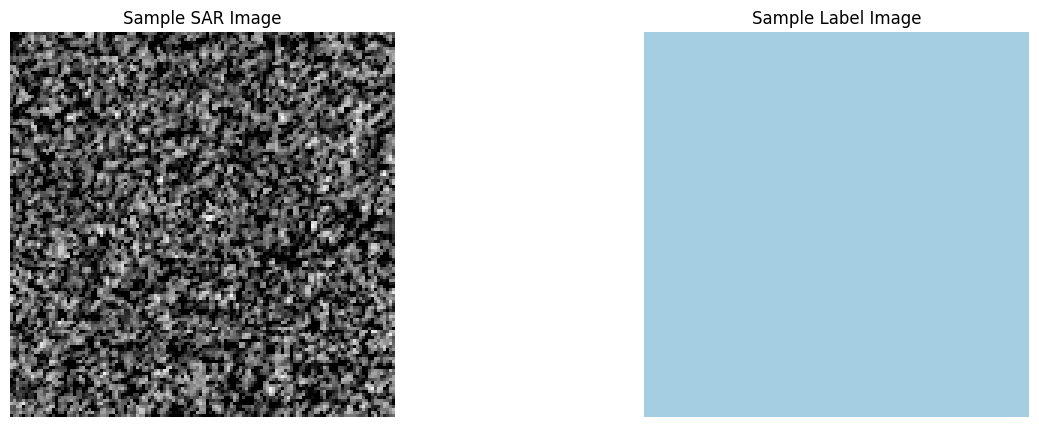

In [2]:
# Display sample images
index = np.random.randint(1080, len(image_dataset))
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_dataset[index].squeeze(), cmap='gray')
plt.title('Sample SAR Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(mask_dataset[index], cmap='Paired')
plt.title('Sample Label Image')
plt.axis('off')
plt.show()

In [3]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [4]:
def merge_classes(mask_image):
    mask_image_copy = mask_image.copy()

    # Define mapping based on merging rules
    merge_class_map = {
        2: 1, 
        4: 3, 
        7: 1,  
        8: 3
    }

    # Apply the merging
    for original_class, new_class in merge_class_map.items():
        mask_image_copy[np.where(mask_image_copy == original_class)] = new_class

    # Define final relabeling to align with target_class_dict
    final_relabel_map = {
        1: 0,  # Bareland
        3: 1,  # Builtup
        5: 2,  # Tree
        6: 3,  # Water
    }

    # Apply the final relabeling
    for original_label, new_label in final_relabel_map.items():
        mask_image_copy[np.where(mask_image_copy == original_label)] = new_label

    return mask_image_copy


In [5]:
labels_dataset = []
for i in range(mask_dataset.shape[0]):
        merged_mask = merge_classes(mask_dataset[i])
        labels_dataset.append(merged_mask)
labels_dataset = np.array(labels_dataset)
print(f"Labels shape:", labels_dataset.shape)

Labels shape: (5000, 128, 128)


In [6]:
#before_Bareland2 = len(np.where(mask_dataset.flatten()==0)[0])
before_Bareland = len(np.where(mask_dataset.flatten()==1)[0])
before_Rangland =   len(np.where(mask_dataset.flatten()==2)[0])
before_Developed_Space =   len(np.where(mask_dataset.flatten()==3)[0])
before_Road =   len(np.where(mask_dataset.flatten()==4)[0])
before_Tree =   len(np.where(mask_dataset.flatten()==5)[0])
before_Water =   len(np.where(mask_dataset.flatten()==6)[0])
before_Agriculture_Land =   len(np.where(mask_dataset.flatten()==7)[0])
before_Building =   len(np.where(mask_dataset.flatten()==8)[0])

after_Water =   len(np.where(labels_dataset.flatten()==3)[0])
after_Tree =   len(np.where(labels_dataset.flatten()==2)[0])
after_Bareland =   len(np.where(labels_dataset.flatten()==0)[0])
after_Builtup =   len(np.where(labels_dataset.flatten()==1)[0])

assert (before_Road+before_Building+before_Developed_Space) == after_Builtup, "Builtup does not match"
assert (before_Rangland+before_Bareland+before_Agriculture_Land) == after_Bareland, "Bareland does not match"
assert before_Tree == after_Tree, "Trees does not match"
assert before_Water == after_Water, "Water does not match"
print(' Merge Validation Passed')
print(' Water = ', np.round(after_Water/(labels_dataset.flatten().shape[0]), 3),
                        ' Trees = ', np.round(after_Tree/(labels_dataset.flatten().shape[0]), 3),
                        ' Bareland = ', np.round(after_Bareland/(labels_dataset.flatten().shape[0]), 3),
                        ' Builtup = ', np.round(after_Builtup/(labels_dataset.flatten().shape[0]), 3))

 Merge Validation Passed
 Water =  0.107  Trees =  0.14  Bareland =  0.336  Builtup =  0.417


In [7]:
n_classes = 4

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

def residual_unit(x, filters):
    """Efficient residual block with reduced parameters"""
    skip = x
    if x.shape[-1] != filters:
        skip = Conv2D(filters, 1, use_bias=False)(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same', use_bias=False)(x)

    return Add()([skip, x])

def build_frrnb(input_shape=(128, 128, 1), n_classes=4):
    """Efficient FRRN-b with optimized architecture"""
    inputs = Input(input_shape)

    # Initial convolution
    x = Conv2D(32, 3, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual stream
    z = x

    # Pooling stream
    y = MaxPooling2D()(x)
    y = Conv2D(64, 3, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    # First set of residual blocks
    for _ in range(2):
        z = residual_unit(z, 32)

    # Further pooling
    y = MaxPooling2D()(y)
    y = Conv2D(128, 3, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    # Middle set of residual blocks
    for _ in range(2):
        z = residual_unit(z, 32)

    # Upsampling path
    y = Conv2DTranspose(64, 3, strides=2, padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    # Final set of residual blocks
    for _ in range(2):
        z = residual_unit(z, 32)

    # Merge streams
    y = Conv2DTranspose(32, 3, strides=2, padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    # Concatenate and final convolution
    x = Concatenate()([y, z])
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    outputs = Conv2D(n_classes, 1, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Prepare data
X = image_dataset.reshape(-1, 128, 128, 1)
y = tf.keras.utils.to_categorical(labels_dataset, num_classes=4)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = build_frrnb()

callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    batch_size = 32,
                    # verbose=12,
                    epochs=40,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    # class_weight=class_weights,
                    callbacks=[callback])


Epoch 1/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 127ms/step - accuracy: 0.4320 - loss: 1.2396 - val_accuracy: 0.3576 - val_loss: 1.4196 - learning_rate: 0.0010
Epoch 2/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.4967 - loss: 1.1368 - val_accuracy: 0.4909 - val_loss: 1.1328 - learning_rate: 0.0010
Epoch 3/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.5082 - loss: 1.1068 - val_accuracy: 0.4763 - val_loss: 1.1312 - learning_rate: 0.0010
Epoch 4/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.5085 - loss: 1.1070 - val_accuracy: 0.5018 - val_loss: 1.0981 - learning_rate: 0.0010
Epoch 5/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.5175 - loss: 1.0918 - val_accuracy: 0.4883 - val_loss: 1.1455 - learning_rate: 0.0010
Epoch 6/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.5244 - loss: 1.0827 - val_accuracy: 0.5208 - val_loss: 1.0742 - learning_rate: 0.0010
Epoch 7/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.5

In [10]:
# Save the model
model.save('frrn_b_model.keras')

In [11]:
code_label ={'Bareland':0, 'Builtup':1, 'Tree':2, 'Water':3}

In [12]:
def count_class(flat_pixels, code_label):
    after_Water =   len(np.where(flat_pixels==code_label['Water'])[0])
    after_Bareland =   len(np.where(flat_pixels==code_label['Bareland'])[0])
    after_Tree =   len(np.where(flat_pixels==code_label['Tree'])[0])
    after_Builtup =   len(np.where(flat_pixels==code_label['Builtup'])[0])
    print(' Water = ', np.round(after_Water/(flat_pixels.shape[0]), 3),
                            ' Tree = ', np.round(after_Tree/(flat_pixels.shape[0]), 3),
                            ' Bareland = ', np.round(after_Bareland/(flat_pixels.shape[0]), 3),
                            ' Builtup = ', np.round(after_Builtup/(flat_pixels.shape[0]), 3))

In [13]:
def convert_to_rgb(masks):
  colour_dict={
    code_label['Water']:[0, 100, 200], #blue
    code_label['Bareland']:[240, 150, 255], #pink
    code_label['Builtup']:[250, 0, 0],  #red
    code_label['Tree']:[0, 100, 0] #green
  }
  try:
    return np.array(list(map(lambda x : colour_dict[x], masks)))
  except:
    return np.array(list(map(lambda x : convert_to_rgb(x), masks)))

In [14]:
def unpatchify(patches, output_shape):
    if len(patches.shape) >3:
        num_patches, patch_height, patch_width, num_channel = patches.shape
    else:
        num_patches, patch_height, patch_width = patches.shape
        num_channel =1
    output_height, output_width = output_shape

    # Compute the number of patches along the height and width of the output image
    num_patches_h = output_height // patch_height
    num_patches_w = output_width // patch_width

    # Reshape patches into a grid
    patches_grid = patches.reshape(num_patches_h, num_patches_w, patch_height, patch_width,num_channel )

    # Concatenate patches along the height axis
    image_rows = [np.concatenate(patches_grid[i], axis=1) for i in range(num_patches_h)]

    # Concatenate rows along the width axis to reconstruct the image
    reconstructed_image = np.concatenate(image_rows, axis=0)

    return reconstructed_image

In [15]:
import numpy as np

def compute_class_wise_iou(y_true, y_pred, class_names):
    iou_dict = {}
    num_classes = len(class_names)
    total_pixels = np.prod(y_true.shape)  # Total number of pixels
    weights = []  # List to store weights for each class
    iou_list = []  # List to store IoU values for weighted IoU and mean IoU

    for cls_idx, cls_name in enumerate(class_names):
        # Create binary masks for the current class
        true_mask = (y_true == cls_idx)
        pred_mask = (y_pred == cls_idx)

        # Compute intersection and union
        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        # Avoid division by zero
        if union == 0:
            iou = float('nan')  # Or you can assign 0
        else:
            iou = intersection / union

        iou_dict[cls_name] = iou
        iou_list.append(iou)

        # Compute weights based on the number of pixels in ground truth
        weights.append(true_mask.sum())

    # Normalize weights
    weights = np.array(weights) / total_pixels

    # Calculate mean IoU and weighted IoU
    mean_iou = np.nanmean(iou_list)
    weighted_iou = np.nansum(np.array(iou_list) * weights)

    # Combine all results into a dictionary
    iou_dict['mean_iou'] = mean_iou
    iou_dict["weighted_iou"] = weighted_iou

    return iou_dict

In [18]:
full_map_predictions = model.predict(image_dataset)
print(full_map_predictions.shape)
full_map_reshape = np.argmax(full_map_predictions, axis=-1).flatten()

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
(5000, 128, 128, 4)


In [19]:
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

from matplotlib import pyplot as plt
import random

from tensorflow.keras.utils import to_categorical
import seaborn as sns

In [20]:
report=classification_report(labels_dataset.flatten(), full_map_reshape, target_names=code_label.keys(), output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
Bareland,0.564161,0.544177,0.553989,2.748733e+07
Builtup,0.614869,0.755358,0.677912,3.418295e+07
Tree,0.523973,0.267291,0.353999,1.145922e+07
Water,0.697906,0.600809,0.645728,8.790502e+06
accuracy,0.599642,0.599642,0.599642,5.996420e-01
macro avg,0.600227,0.541908,0.557907,8.192000e+07
weighted avg,0.594050,0.599642,0.587567,8.192000e+07


In [21]:
pd.DataFrame.from_dict( compute_class_wise_iou(labels_dataset.flatten(), full_map_reshape, code_label.keys()), orient='index', columns=['IoU'])

,IoU
Bareland,0.383115
Builtup,0.512758
Tree,0.215066
Water,0.476808
mean_iou,0.396937
weighted_iou,0.423758


In [22]:
print('Full Map Predictions : ')
count_class(full_map_reshape, code_label)
print('Full map true labels : ')
count_class(labels_dataset.flatten(), code_label)

Full Map Predictions : 
 Water =  0.092  Tree =  0.071  Bareland =  0.324  Builtup =  0.513
Full map true labels : 
 Water =  0.107  Tree =  0.14  Bareland =  0.336  Builtup =  0.417


In [23]:
full_map_pred_colour=convert_to_rgb(np.argmax(full_map_predictions, axis=-1))
full_map_test_colour=convert_to_rgb(labels_dataset)

In [24]:
print(full_map_pred_colour.shape)
print(full_map_test_colour.shape)
print(image_dataset.shape)

(5000, 128, 128, 3)
(5000, 128, 128, 3)
(5000, 128, 128)


In [25]:
# First get model predictions
predictions = model.predict(image_dataset)
y_pred = np.argmax(predictions, axis=-1).flatten()
y_true = labels_dataset.flatten()

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


In [26]:
# 1. Overall Metrics
print("\n=== Overall Metrics ===")
accuracy = np.mean(y_pred == y_true)
print(f"Overall Accuracy: {accuracy:.4f}")

# Calculate Mean IoU
def compute_iou(y_true, y_pred, class_id):
    intersection = np.sum((y_true == class_id) & (y_pred == class_id))
    union = np.sum((y_true == class_id) | (y_pred == class_id))
    return intersection / union if union > 0 else 0

class_names = ['Bareland', 'Builtup', 'Tree', 'Water']
ious = [compute_iou(y_true, y_pred, i) for i in range(len(class_names))]
mean_iou = np.mean(ious)
print(f"Mean IoU: {mean_iou:.4f}")


=== Overall Metrics ===
Overall Accuracy: 0.5996
Mean IoU: 0.3969


In [27]:
# 2. Per-Class Metrics
print("\n=== Per-Class Metrics ===")
report = classification_report(y_true, y_pred, 
                            target_names=class_names,
                            output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
print(df_metrics)

# Print per-class IoU
print("\n=== Per-Class IoU ===")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {ious[i]:.4f}")


=== Per-Class Metrics ===
              precision    recall  f1-score       support
Bareland       0.564161  0.544177  0.553989  2.748733e+07
Builtup        0.614869  0.755358  0.677912  3.418295e+07
Tree           0.523973  0.267291  0.353999  1.145922e+07
Water          0.697906  0.600809  0.645728  8.790502e+06
accuracy       0.599642  0.599642  0.599642  5.996420e-01
macro avg      0.600227  0.541908  0.557907  8.192000e+07
weighted avg   0.594050  0.599642  0.587567  8.192000e+07

=== Per-Class IoU ===
Bareland: 0.3831
Builtup: 0.5128
Tree: 0.2151
Water: 0.4768


In [28]:
# 3. Model Complexity
print("\n=== Model Complexity ===")
total_params = model.count_params()
trainable_params = np.sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total Parameters: {total_params/1e6:.2f}M")
print(f"Trainable Parameters: {trainable_params/1e6:.2f}M")


=== Model Complexity ===
Total Parameters: 0.30M
Trainable Parameters: 0.30M


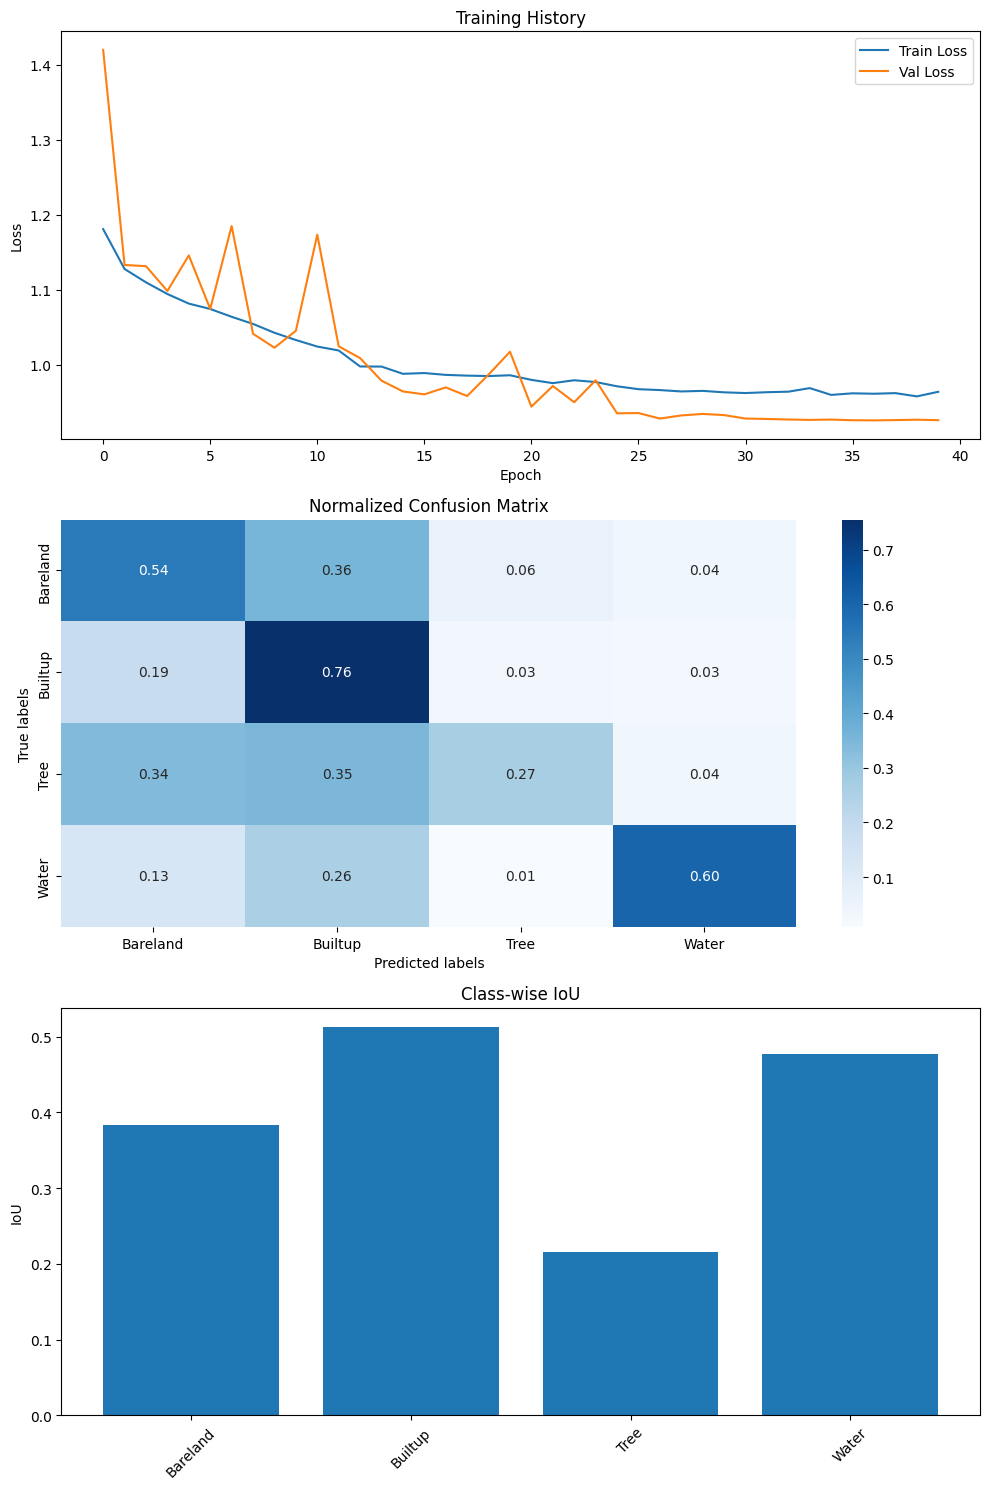

In [29]:
plt.figure(figsize=(10, 15))  # Adjust figure size for vertical layout

# Plot 1: Training History
plt.subplot(3, 1, 1)  # 3 rows, 1 column, first plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot 2: Confusion Matrix

plt.subplot(3, 1, 2)  # 3 rows, 1 column, second plot
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix_norm, 
            annot=True, 
            fmt='.2f',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')

# Plot 3: Class-wise IoU
plt.subplot(3, 1, 3)  # 3 rows, 1 column, third plot
plt.bar(class_names, ious)
plt.title('Class-wise IoU')
plt.xticks(rotation=45)
plt.ylabel('IoU')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [30]:
# 5. Classification Report for Each Class
print("\n=== Detailed Class-wise Performance ===")
for class_name in class_names:
    print(f"\n{class_name}:")
    print(f"  Precision: {report[class_name]['precision']:.4f}")
    print(f"  Recall: {report[class_name]['recall']:.4f}")
    print(f"  F1-Score: {report[class_name]['f1-score']:.4f}")

# 6. Additional Model Performance Metrics
print("\n=== Additional Performance Metrics ===")
val_accuracy = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
print(f"Final Validation Accuracy: {val_accuracy:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")


=== Detailed Class-wise Performance ===

Bareland:
  Precision: 0.5642
  Recall: 0.5442
  F1-Score: 0.5540

Builtup:
  Precision: 0.6149
  Recall: 0.7554
  F1-Score: 0.6779

Tree:
  Precision: 0.5240
  Recall: 0.2673
  F1-Score: 0.3540

Water:
  Precision: 0.6979
  Recall: 0.6008
  F1-Score: 0.6457

=== Additional Performance Metrics ===
Final Validation Accuracy: 0.5977
Final Validation Loss: 0.9257


In [31]:
import time
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import tensorflow as tf
from scipy import stats

In [32]:
# Calculate FLOPS
def get_flops():
    concrete_func = tf.function(lambda x: model(x)).get_concrete_function(
        tf.TensorSpec([1, 128, 128, 1], model.inputs[0].dtype))
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()
    
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
    return flops.total_float_ops

# Calculate Speed (FPS)
def measure_fps():
    # Warmup
    for i in range(10):
        _ = model.predict(np.zeros((1, 128, 128, 1)))
        
    # Measure time for 100 predictions
    start_time = time.time()
    num_predictions = 100
    for i in range(num_predictions):
        _ = model.predict(np.zeros((1, 128, 128, 1)))
    end_time = time.time()
    
    fps = num_predictions / (end_time - start_time)
    return fps

# Print Model Performance Stats
print("\n=== Model Performance Statistics ===")
flops = get_flops()
print(f"FLOPS: {flops/1e9:.2f} GFLOPs")

fps = measure_fps()
print(f"Speed: {fps:.2f} FPS")


=== Model Performance Statistics ===
FLOPS: 4.27 GFLOPs
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/